In [212]:
import math
import numpy as np
from diagonalize import State, delta, neg_1_pow, Interaction, Molecule
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import solve_ivp

int_wigner_arr = np.load("wigner3j_integer_N=10.npy")
halfint_wigner_arr = np.load("wigner3j_halfint_N=3.5.npy")

def T_int(n3, n1, m3, m1, n2, m2, N=10):
    m1_ = m1 + N
    m2_ = m2 + 2
    m3_ = m3 + N
    
    return m2_ + 5*n2 + 15*m1_ + (15 + 30*N)*m3_ + (15+ 60*N + 60*N*N)*n1 + (15 + 75*N + 120*N*N + 60 *N*N*N)*n3

def T_half_int(n3, n1, m3, m1, n2, m2, N = 7/2):
    n3 = n3 - 0.5 
    n1 = n1 - 0.5 
    
    n2 = n2
    m2 = m2 + 2 
    
    m3 = m3 + N 
    m1 = m1 + N 
    
    return int(m2     + 5 * n2         + 15 * m1               + (15+30*N)*m3  + (15+60*N+60*N*N)*n1     + (60*N*N*N + 90*N*N + 45*N + 7.5)*n3)
    
def wigner_3j(n1, n2, n3, m1, m2, m3):
    if n1 == int(n1) and n2 == int(n2) and n3 == int(n3):
        return int_wigner_arr[T_int(n3,n1,m3,m1,n2,m2)]
    return halfint_wigner_arr[T_half_int(n3,n1,m3,m1,n2,m2)]

from scipy.constants import fine_structure as alpha
Na23Cs133 = {"I1":1.5,
            "I2":3.5,
            "g1":1.478,
            "g2":0.738,
            "d0":4.69,
            "Brot":0.058*alpha*100,
            "Drot":0,
            "Q1":-0.097e6,
            "Q2":0.150e6,
            "C1":14.2,
            "C2":854.5,
            "C3":105.6,
            "C4":3941.8,
            "MuN":0*0.5, #0.5 is bohr magneton
            "Mu1":1.478*0.5,
            "Mu2":0.738*0.5,
            "a0":0, #Not reported
            "a2":0, #Not reported
            "Beta":0}

def rotational(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return n*(n+1)
    return 0

def stark(state1: State, state2:State):
    
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_)):
        return 0
    
    wig1 = wigner_3j(n, 1, n_, -mn, 0, mn)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_3j(n, 1, n_, 0, 0, 0)
    if wig2 == 0:
        return 0
    
    other = -neg_1_pow(mn+m1+m2) * math.sqrt((2*n + 1) * (2*n_ + 1))
    return wig1 * wig2 * other

int_rotational = Interaction(Na23Cs133['Brot'], rotational)
int_stark = Interaction(Na23Cs133['d0'], stark)

N = 4
NaCs = Molecule(range(N+1), 0, 0)
NaCs.add_interaction(int_rotational)
NaCs.add_changing_interaction(int_stark)

NaCs.find_H_zero()
NaCs.find_H_prime()

E_range = np.linspace(0, 10, int(60))
eigenvalues_and_eigenvectors_E_1 = NaCs.compute_eigenval_over_range([E_range[-1:]])
eigenvalues_and_eigenvectors_E_2 = NaCs.compute_eigenval_over_range([E_range[-20:-19]])

eigenvalues_1, eigenvectors_1 = eigenvalues_and_eigenvectors_E_1[0]
eigenvalues_2, eigenvectors_2 = eigenvalues_and_eigenvectors_E_2[0]
basis = NaCs.states

def dipole_dipole_matrix_elem(evec1, evec2, basis):
    if (len(evec1) != len(evec2) or len(evec1) != len(basis)):
        raise('ArithmeticError')
    else:
        value = 0
        for i, a in enumerate(evec1):
            for j, b in enumerate(evec2):
                value += a * b * stark(basis[i], basis[j])
        return value



H has dim 25


In [213]:
one_mol_basis_size = (N+1)**2
full_basis_size = (N+1)**4
print(one_mol_basis_size, full_basis_size)

25 625


In [214]:
eigenvalues_q = np.zeros(full_basis_size)
states1 = np.zeros(full_basis_size)
states2 = np.zeros(full_basis_size)
for s1 in range(one_mol_basis_size):
    for s2 in range(one_mol_basis_size):
        q = s1*one_mol_basis_size + s2
        eigenvalues_q[q] = eigenvalues_1[s1]+eigenvalues_2[s2]
        states1[q] = s1
        states2[q] = s2

states_q = np.zeros((full_basis_size, 3))
for i in range(full_basis_size):
    states_q[i] = np.array([eigenvalues_q[i], states1[i], states2[i]])
states_q = np.array(sorted(states_q, key = lambda x: x[0]))

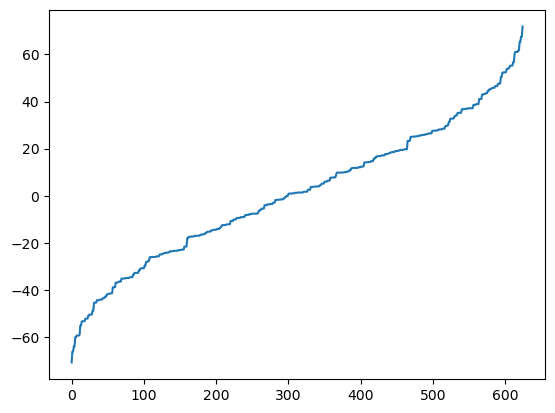

In [215]:
plt.plot(range(full_basis_size), [elem[0] for elem in states_q])

In [216]:
dim = len(basis)
dip_dip_matrix_1 = np.zeros((dim,dim))
for i in tqdm(range(dim)):
    for j in range(dim):
        dip_dip_matrix_1[i][j] = dipole_dipole_matrix_elem(eigenvectors_1[i], eigenvectors_1[j], basis)
dim = len(basis)
dip_dip_matrix_2 = np.zeros((dim,dim))
for i in tqdm(range(dim)):
    for j in range(dim):
        dip_dip_matrix_2[i][j] = dipole_dipole_matrix_elem(eigenvectors_2[i], eigenvectors_2[j], basis)


100%|██████████| 25/25 [00:00<00:00, 93.40it/s]


In [217]:
np.save("dip_dip_matrix1.npy", dip_dip_matrix_1)
np.save("dip_dip_matrix2.npy", dip_dip_matrix_2)
dip_dip_matrix_1 = np.load("dip_dip_matrix1.npy")
dip_dip_matrix_2 = np.load("dip_dip_matrix2.npy")
        

In [218]:
H_dd_unitless = np.zeros((full_basis_size,full_basis_size))
for i in tqdm(range(full_basis_size)):
    for j in range(full_basis_size):
        s1 = math.floor(i/one_mol_basis_size)
        s2 = int(i%one_mol_basis_size)
        
        s1_ = math.floor(j/one_mol_basis_size)
        s2_ = int(j%one_mol_basis_size)
        
        H_dd_unitless[i][j] += dip_dip_matrix_1[s1_][s1]*dip_dip_matrix_2[s2_][s2]

100%|██████████| 625/625 [00:00<00:00, 1874.51it/s]


In [219]:
H_l1_unitless = np.zeros((full_basis_size,full_basis_size))
for i in tqdm(range(full_basis_size)):
    for j in range(full_basis_size):
        s1 = math.floor(i/one_mol_basis_size)
        s2 = int(i%one_mol_basis_size)
        
        s1_ = math.floor(j/one_mol_basis_size)
        s2_ = int(j%one_mol_basis_size)
        
        H_l1_unitless[i][j] += H_l1_unitless[s1_][s1]*delta(s2_,s2)

100%|██████████| 625/625 [00:00<00:00, 2137.11it/s]


In [220]:
H_l2_unitless = np.zeros((full_basis_size,full_basis_size))
for i in tqdm(range(full_basis_size)):
    for j in range(full_basis_size):
        s1 = math.floor(i/one_mol_basis_size)
        s2 = int(i%one_mol_basis_size)
        
        s1_ = math.floor(j/one_mol_basis_size)
        s2_ = int(j%one_mol_basis_size)
        
        H_l2_unitless[i][j] += H_l2_unitless[s1_][s1]*delta(s1_,s1)

100%|██████████| 625/625 [00:00<00:00, 2108.46it/s]


In [221]:
def H_l_t(t, w):
    return math.cos(w*t)

In [222]:
def C_part(t, Energies=eigenvalues_q):
    Eq_minus_Ek = np.zeros((full_basis_size,full_basis_size))
    for i in range(full_basis_size):
        for j in range(full_basis_size):
            Eq_minus_Ek[i][j] = (Energies[i]-Energies[j])
    return -1j*(np.cos(Eq_minus_Ek*t) + 1j*np.sin(Eq_minus_Ek)*t)

In [223]:
def norm(x):
    sum = 0
    for elem in x:
        sum += abs(elem)*abs(elem)
    return sum
def solve_ivp_renormed(func, t_span, y0, t_eval, method):
    sol = np.array([])
    y0 = y0
    sol = np.append(sol, y0)
    for i, elem in enumerate(t_eval[1:]):
        #print(i)
        
        # solving over a single timestep using python solver
        print(i, len(t_eval[1:]))
        pysol = solve_ivp(func, t_eval[i:i+2], y0, method = method)
        
        #extracting and renormalizing solution from python solver solution
        y0 = pysol.y.T[-1]
        y0 = y0 / math.sqrt(norm(y0))
        
        # adding this solution point to our solution
        sol = np.vstack((sol, y0))
        
        #renormalization
    print("done")
    return sol.T

In [228]:
def rhs (t, psi):
    #print(np.sum(C_part(t)))
    system = np.multiply(C_part(t),H_dd_unitless + (H_l1_unitless+H_l2_unitless)*H_l_t(eigenvalues_q[0] - eigenvalues_q[1],t))
    dpsi_dt = np.dot(system, psi)
    return dpsi_dt

In [229]:
# We start in the |00> state
psi_0 = np.zeros(full_basis_size, dtype=np.complex_)
psi_0[0] = 1+0j
for i in range(1,full_basis_size):
    psi_0[i] = 0 + 0j

t0 = 0
tfinal = 20
ts = np.linspace(t0, tfinal, 20)

sol = solve_ivp_renormed(rhs, [t0, tfinal], psi_0, t_eval=ts, method = 'DOP853')

0 19
1 19
2 19
3 19
4 19
5 19
6 19
7 19
8 19
9 19
10 19
11 19
12 19
13 19
14 19
15 19
16 19
17 19
18 19
done


In [236]:
sortedsol = sorted(sol, key = lambda x: abs(x[19])**2)

In [246]:
sortedsol[0]

array([ 0.        +0.00000000e+00j, -0.0004315 -2.04129205e-05j,
       -0.00679209-6.09897931e-04j, -0.03169706+1.77205892e-03j,
       -0.07633941+3.02560476e-03j, -0.08571931+5.49666317e-03j,
       -0.01764895+4.93224050e-03j, -0.00122639+1.10252811e-02j,
        0.00935743+5.60005343e-03j,  0.05097948-1.68627575e-03j,
        0.03856377-3.53600557e-03j,  0.0265129 -1.29670274e-02j,
       -0.00142784-3.24249800e-03j, -0.02995125+2.82882340e-04j,
        0.02767281+1.26669708e-02j, -0.00187575-6.49055578e-03j,
       -0.03944758-7.57603656e-03j, -0.03941966-7.95323066e-03j,
       -0.0282338 +7.37786907e-03j, -0.00021409-2.86835998e-04j])

In [242]:
sol.shape

(625, 20)

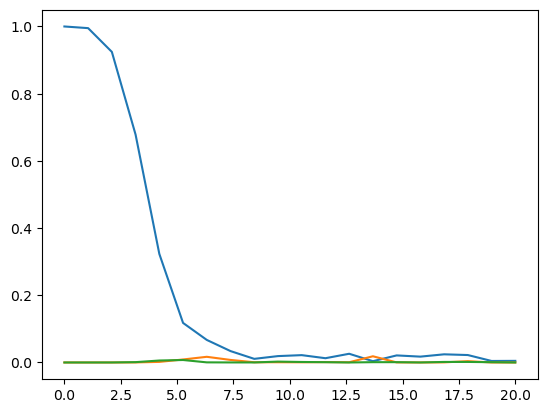

In [250]:
normedsol0 = [abs(elem)**2 for elem in sol[0]]
normedsol1 = [abs(elem)**2 for elem in sol[1]]
normedsol2 = [abs(elem)**2 for elem in sortedsol[0]]
plt.plot(ts, normedsol0)
plt.plot(ts, normedsol1)
plt.plot(ts, normedsol2)

In [251]:
sum = 0
for elem in sortedsol:
    sum += abs(elem[-1])**2